# Random Forest Regessor Base Model

## Package imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import ta
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate, ParameterGrid, train_test_split, GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from ta.momentum import RSIIndicator
from ta.trend import SMAIndicator
from ta.volatility import BollingerBands
from datetime import datetime as dt

## Custom TimedSplit Class

In [2]:
class train_val_split:
    
    def __init__(self, df, duration=30, window=1, prediction_period=5, start = '2018-01-01', end = '2020-03-31'):
        self.duration = duration # training period, for dates
        self.window = window # rolling window freq, for dates
        self.prediction_period = prediction_period # prediciton horizon, for dates
        self.start = start
        self.end = end
        self.df = df.loc[(df.index >= start) & (df.index <= end)].reset_index()
        self.start_ind = self.df[self.df.Date>=self.start].index.min()
        
    @staticmethod
    def _strfdate(date):
        return dt.strftime(date, '%Y-%m-%d')
           
    
    def split_by_date(self):
        self.end_ind = self.start_ind + self.duration
        
        dates = []
        
        while self.end_ind <=  len(self.df) - self.prediction_period:
            date_start = self._strfdate(self.df.Date[self.start_ind])
            date_end = self._strfdate(self.df.Date[self.end_ind])
            
            dates.append([date_start, date_end])
            
            self.start_ind += self.window
            self.end_ind = self.start_ind + self.duration
            
        return dates
    
    def _chk_split(self, date_split):
        for n in range(len(date_split)-1):
            if date_split[n] >= date_split[n+1]:
                return False
        if date_split[0] < self.start:
            return False
        if date_split[-1] > self.end:
            return False
        return True
            
    
    def split_by_index(self, date_split = ['2018-09-30','2019-06-30','2020-03-31']):
        
        if not self._chk_split(date_split):
            return "Check date split again"
        
        ind_out = []            
        for n, date in enumerate(date_split):
            self.train_end_ind = self.df[self.df.Date<=date].index.max()
            
            if n < len(date_split)-1:
                val_end = self.df[self.df.Date<=date_split[n+1]].index.max()
            else:
                val_end = self.df.index.max()
            
            #check boundary_dates
            print(self.df.Date[self.train_end_ind], self.df.Date[self.train_end_ind+1], self.df.Date[val_end])
                
            ind_out.append((list(range(self.start_ind, self.train_end_ind+1)), list(range(self.train_end_ind+1, val_end+1))))
            
        return ind_out
    
    def get_val_map(self, start='2020-06-01', end='2020-12-31'):
        start_ind = self.df[self.df.Date>=start].index.min()
        end_ind = self.df[self.df.Date<=end].index.max()
        
        return {self._strfdate(self.df.Date[n-5]):self._strfdate(self.df.Date[n]) for n in range(start_ind, end_ind+1)}

## Download Data

In [3]:
def get_data(ticker, start="2017-01-01", end="2022-01-01"):
    return yf.download(ticker, start, end)

In [4]:
aapl_data = get_data("AAPL")

[*********************100%***********************]  1 of 1 completed


In [5]:
aapl_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.332472,115127600
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.301878,84472400
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.440720,88774400
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.746628,127007600
2017-01-09,29.487499,29.857500,29.485001,29.747499,28.000784,134247600
...,...,...,...,...,...,...
2021-12-27,177.089996,180.419998,177.070007,180.330002,180.330002,74919600
2021-12-28,180.160004,181.330002,178.529999,179.289993,179.289993,79144300
2021-12-29,179.330002,180.630005,178.139999,179.380005,179.380005,62348900


## Plot the Adjusted Closing Price

In [6]:
def plot_chart(df):
    df['Adj Close'].plot()
    plt.ylabel("Adjusted Close Prices")
    plt.show()

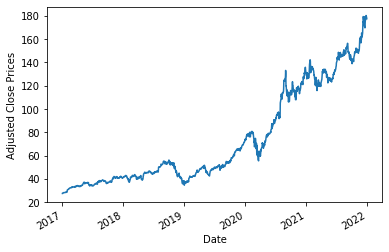

In [7]:
plot_chart(aapl_data)

## % Change Histogram

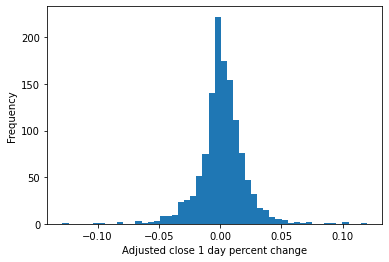

In [8]:
aapl_data['Adj Close'].pct_change().plot.hist(bins=50)
plt.xlabel("Adjusted close 1 day percent change")
plt.show()

## Add features, target and drop NaN

In [9]:
def add_features_target(df):
    feature_names = []
    # add 14,50,200 day (MA, RSI, BB Width), volume, VIX and append names to feature names
    for n in [14, 50, 200]:
        df[str(n) + 'd' + ' ma'] = SMAIndicator(df['Adj Close'], window=n).sma_indicator()
        df[str(n) + 'd' + ' rsi'] = RSIIndicator(df['Adj Close'], window=n).rsi()
        df[str(n) + 'd' + ' bbwidth'] = BollingerBands(df['Adj Close'], window=n).bollinger_wband()
        feature_names = feature_names + [str(n) + 'd' + ' ma' , str(n) + 'd' + ' rsi', str(n) + 'd' + ' bbwidth']
    
    # add VIX
    df["VIX"] = get_data("^VIX")["Adj Close"]
    feature_names.append("VIX")
    
    # add target label 5 day future close column 
    df['5d_future_close'] = df['Adj Close'].shift(-5)
    
    # add vol to feature_names
    feature_names.append("Volume")
    
    # add Adj Close to feature_names
    feature_names.append("Adj Close")

    return df, feature_names

In [10]:
aapl_data, feature_names = add_features_target(aapl_data)

[*********************100%***********************]  1 of 1 completed


In [11]:
aapl_data

,Open,High,Low,Close,Adj Close,Volume,14d ma,14d rsi,14d bbwidth,50d ma,50d rsi,50d bbwidth,200d ma,200d rsi,200d bbwidth,VIX,5d_future_close
Date,,,,,,,,,,,,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,27.332472,115127600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.850000,28.029018
2017-01-04,28.962500,29.127501,28.937500,29.004999,27.301878,84472400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.850000,28.179625
2017-01-05,28.980000,29.215000,28.952499,29.152500,27.440720,88774400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.670000,28.061962
2017-01-06,29.195000,29.540001,29.117500,29.477501,27.746628,127007600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.320000,28.012547
2017-01-09,29.487499,29.857500,29.485001,29.747499,28.000784,134247600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.560000,28.238457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,177.089996,180.419998,177.070007,180.330002,180.330002,74919600,174.859286,66.906727,7.189071,159.531765,63.020251,27.625799,142.548195,57.879058,40.039612,17.680000,NaN
2021-12-28,180.160004,181.330002,178.529999,179.289993,179.289993,79144300,175.438571,64.966891,7.201413,160.224987,62.353721,27.831235,142.827573,57.698710,40.433600,17.540001,NaN
2021-12-29,179.330002,180.630005,178.139999,179.380005,179.380005,62348900,175.745714,65.061307,7.542623,160.885858,62.388853,28.054260,143.099537,57.710172,40.839349,16.950001,NaN


In [12]:
feature_names

['14d ma',
 '14d rsi',
 '14d bbwidth',
 '50d ma',
 '50d rsi',
 '50d bbwidth',
 '200d ma',
 '200d rsi',
 '200d bbwidth',
 'VIX',
 'Volume',
 'Adj Close']

## Scale Features

In [13]:
def scale_features(df):
    #Instantiate scaler
    scaler = StandardScaler()
    #fit and transform features
    df[feature_names] = scaler.fit_transform(df[feature_names])
    #Show scaled features
    return df

In [14]:
# Scale features only but not target label
aapl_data = scale_features(aapl_data)
aapl_data

,Open,High,Low,Close,Adj Close,Volume,14d ma,14d rsi,14d bbwidth,50d ma,50d rsi,50d bbwidth,200d ma,200d rsi,200d bbwidth,VIX,5d_future_close
Date,,,,,,,,,,,,,,,,,
2017-01-03,28.950001,29.082500,28.690001,29.037500,-1.123305,-0.104462,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.634851,28.029018
2017-01-04,28.962500,29.127501,28.937500,29.004999,-1.124048,-0.650566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.748808,28.179625
2017-01-05,28.980000,29.215000,28.952499,29.152500,-1.120674,-0.573929,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.769320,28.061962
2017-01-06,29.195000,29.540001,29.117500,29.477501,-1.113238,0.107173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.809206,28.012547
2017-01-09,29.487499,29.857500,29.485001,29.747499,-1.107061,0.236150,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.781856,28.238457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,177.089996,180.419998,177.070007,180.330002,2.595451,-0.820744,2.510499,0.656526,-0.434753,2.235153,0.905338,0.752399,2.128221,0.873146,-0.317903,-0.084437,NaN
2021-12-28,180.160004,181.330002,178.529999,179.289993,2.570173,-0.745483,2.524811,0.510734,-0.432461,2.252961,0.812802,0.774174,2.136422,0.813207,-0.297046,-0.100391,NaN
2021-12-29,179.330002,180.630005,178.139999,179.380005,2.572361,-1.044683,2.532399,0.517830,-0.369075,2.269937,0.817679,0.797813,2.144406,0.817017,-0.275567,-0.167626,NaN


In [15]:
aapl_data.tail(10)

,Open,High,Low,Close,Adj Close,Volume,14d ma,14d rsi,14d bbwidth,50d ma,50d rsi,50d bbwidth,200d ma,200d rsi,200d bbwidth,VIX,5d_future_close
Date,,,,,,,,,,,,,,,,,
2021-12-17,169.929993,173.470001,169.690002,171.139999,2.372079,1.326126,2.415201,-0.029468,0.678785,2.150824,0.432061,0.742994,2.087513,0.498585,-0.378595,0.358857,180.330002
2021-12-20,168.279999,170.580002,167.460007,169.750000,2.338294,-0.240359,2.423054,-0.189816,0.583618,2.164726,0.312849,0.728853,2.095428,0.419248,-0.378146,0.507001,179.289993
2021-12-21,171.559998,173.199997,169.119995,172.990005,2.417045,-0.530969,2.437561,0.092962,0.444058,2.180338,0.502547,0.728315,2.103128,0.560274,-0.367201,0.295041,179.380005
2021-12-22,173.039993,175.860001,172.149994,175.639999,2.481456,-0.514056,2.458526,0.305060,0.236957,2.197979,0.651505,0.728153,2.111380,0.674155,-0.354129,0.023822,178.199997
2021-12-23,175.850006,176.850006,175.270004,176.279999,2.497012,-0.937660,2.484010,0.355477,-0.223335,2.216257,0.686991,0.716053,2.119435,0.701523,-0.338573,-0.052529,177.570007
2021-12-27,177.089996,180.419998,177.070007,180.330002,2.595451,-0.820744,2.510499,0.656526,-0.434753,2.235153,0.905338,0.752399,2.128221,0.873146,-0.317903,-0.084437,NaN
2021-12-28,180.160004,181.330002,178.529999,179.289993,2.570173,-0.745483,2.524811,0.510734,-0.432461,2.252961,0.812802,0.774174,2.136422,0.813207,-0.297046,-0.100391,NaN
2021-12-29,179.330002,180.630005,178.139999,179.380005,2.572361,-1.044683,2.532399,0.517830,-0.369075,2.269937,0.817679,0.797813,2.144406,0.817017,-0.275567,-0.167626,NaN
2021-12-30,179.470001,180.570007,178.089996,178.199997,2.543679,-1.090571,2.538823,0.338598,-0.354541,2.285174,0.710886,0.816951,2.152334,0.748786,-0.258026,-0.124322,NaN


In [16]:
total_train = aapl_data.loc[(aapl_data.index >= "2018-01-01") & (aapl_data.index <= "2020-12-31")]
X_train = total_train[feature_names]
y_train = total_train['5d_future_close']
total_test = aapl_data.loc[(aapl_data.index >= "2021-01-01") & (aapl_data.index <= "2021-12-23")]
X_test = total_test[feature_names]
y_test = total_test['5d_future_close']

## Train Test Split

In [17]:
split = train_val_split(X_train, end = '2020-12-31')

In [56]:
import datetime
import calendar


date_split = [dt.strftime(datetime.date(y,m,calendar.monthrange(y,m)[1]), '%Y-%m-%d') for y in range(2018,2021) for m in range(2,13,2)]
if date_split[-1] =='2020-12-31':
    date_split = date_split[:-1]
    

In [57]:
date_split

['2018-02-28',
 '2018-04-30',
 '2018-06-30',
 '2018-08-31',
 '2018-10-31',
 '2018-12-31',
 '2019-02-28',
 '2019-04-30',
 '2019-06-30',
 '2019-08-31',
 '2019-10-31',
 '2019-12-31',
 '2020-02-29',
 '2020-04-30',
 '2020-06-30',
 '2020-08-31',
 '2020-10-31']

In [58]:
splits = split.split_by_index(date_split)
for x in splits:
    print(x)

2018-02-28 00:00:00 2018-03-01 00:00:00 2018-04-30 00:00:00
2018-04-30 00:00:00 2018-05-01 00:00:00 2018-06-29 00:00:00
2018-06-29 00:00:00 2018-07-02 00:00:00 2018-08-31 00:00:00
2018-08-31 00:00:00 2018-09-04 00:00:00 2018-10-31 00:00:00
2018-10-31 00:00:00 2018-11-01 00:00:00 2018-12-31 00:00:00
2018-12-31 00:00:00 2019-01-02 00:00:00 2019-02-28 00:00:00
2019-02-28 00:00:00 2019-03-01 00:00:00 2019-04-30 00:00:00
2019-04-30 00:00:00 2019-05-01 00:00:00 2019-06-28 00:00:00
2019-06-28 00:00:00 2019-07-01 00:00:00 2019-08-30 00:00:00
2019-08-30 00:00:00 2019-09-03 00:00:00 2019-10-31 00:00:00
2019-10-31 00:00:00 2019-11-01 00:00:00 2019-12-31 00:00:00
2019-12-31 00:00:00 2020-01-02 00:00:00 2020-02-28 00:00:00
2020-02-28 00:00:00 2020-03-02 00:00:00 2020-04-30 00:00:00
2020-04-30 00:00:00 2020-05-01 00:00:00 2020-06-30 00:00:00
2020-06-30 00:00:00 2020-07-01 00:00:00 2020-08-31 00:00:00
2020-08-31 00:00:00 2020-09-01 00:00:00 2020-10-30 00:00:00
2020-10-30 00:00:00 2020-11-02 00:00:00 

## Random Grid Search CV

In [59]:
def rf_random_grid_search():
    
    # Trees 
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    # Features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
    max_depth.append(None)
    # Minimum samples to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples at each tree
    bootstrap = [True, False]

    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    # Instantiate model
    rf = RandomForestRegressor()
    # Random search of parameters with 5 folds
    model = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring = 'neg_mean_absolute_error', n_iter = 10, cv = splits, verbose=2, random_state=42, n_jobs = -1)
    
    return model

## Train the model

In [60]:
rf_random = rf_random_grid_search()
# Fit
rf_random.fit(X_train, y_train)

Fitting 17 folds for each of 10 candidates, totalling 170 fits


RandomizedSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                        [40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
                         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
                         68, 69, ...]),
                       ([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                         16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, ...],
                        [82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95,
                         96, 97, 98, 99, 1...
                   estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                    

## Base Model Best Parameters and Score

In [61]:
rf_random.best_params_

{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': True}

In [62]:
(rf_random.best_score_)

-5.579084271300368

## Predict with X_test and Score for y_test

In [63]:
y_pred = rf_random.predict(X_test)

In [64]:
test_score = metrics.mean_absolute_error(y_test, y_pred)
test_score

23.628740516833535